Latent Dirichlet Allocation (LDA) adalah sebuah metode untuk mendeteksi topik-topik yang ada pada koleksi dokumen beserta proporsi kemunculan topik tersebut, baik di koleksi maupun di dokumen tertentu. LDA juga mampu mengasosiasikan kata-kata yang ada pada dokumen dan koleksi ke topik tertentu. Kasus disini menggunakan LDA untuk mendeteksi topik-topik yang ada pada kumpulan tweet. Tentunya, mengetahui distribusi topik (yang tersembunyi) pada kumpulan tweet tersebut akan sangat berguna untuk mengorganisasikan, memahami, bahkan membuat summary dari apa-apa yang "diperbincangkan" pada kumpulan tweet tersebut.

Library yang akan berguna pada kasus ini. 

- matplotlib digunakan untuk visualisasi.
- gensim untuk implementasi LDA, gensim memberikan fungsionalitas yang baik dalam hal API dan efisiensi komputasi. 
- nltk digunakan untuk preprocessing seperti proses stopword removal, tokenization, dan stemming.
- scikit-learn digunakan untuk proses clustering dokumen tweet, serta reduksi dimensi dari vektor tweet agar bisa di-plot ke bidang 2-dimensi.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import re
import numpy as np
import pandas as pd
import gensim
import nltk

from nltk.stem.snowball import SnowballStemmer

from gensim.corpora import Dictionary, MmCorpus
from gensim.models import ldamodel

from sklearn.cluster import KMeans
from sklearn.manifold import MDS
from sklearn.decomposition import PCA

Pembuatan Fungsi untuk memuat/load dataset yang berupa kumpulan twitter account name beserta tweet yang di-post.

In [2]:
def load_dataset(filename):
    file = open(filename, 'r')

    acc_names = []
    tweets = []

    for line in file:
        line = line.strip()
        parts = line.split('###')
        acc_names.append(parts[0])
        tweets.append(parts[1])

    return acc_names, tweets

Hyper-parameter yang perlu ditentukan pertama kali adalah "banyaknya topik" yang akan ditemukan oleh LDA. Di satu sisi, ini sepertinya adalah kelemahan vanilla LDA karena tidak bisa menentukan banyaknya topik secara otomatis. Namun, saat ini, sudah ada banyak varian dari LDA yang mampu menentukan topik secara otomatis, termasuk salah satunya adalah Hierachical Dirichlet Process (HDP)

In [3]:
# config variables
num_topics=4

Berikutnya pra-pemrosesan seperti lowercasing, stopword removal, dan stemming. Perlu dilakukan stopword removal, Kata-kata topik biasanya adalah content word yang mayoritas merupakan kata benda dan kata kerja.

In [4]:
# definisikan beberapa fungsi untuk kebutuhkan pre-processing, pre-processing yang dilakukan adalah
# 1. lowercasing
# 2. stopword removal
# 3. stemming

stemmer = SnowballStemmer("english")
stopwords = nltk.corpus.stopwords.words('english')

def preprocess(text):

    # tokenizing and lowercasing
    tokens = [word.lower() for word in text.split()]
    filtered_tokens = []

    # buat yang bukan terdiri dari alfabet, dan merupakan stopword
    for token in tokens:
        if re.search('[a-zA-Z]', token) and (token not in stopwords):
            filtered_tokens.append(token)

    # lakukan stemming dengan snowball stemmer
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

Muat/load dataset dengan fungsi yang sudah dibangun sebelumnya, dan kenakan pre-processing terhadap dataset yang sudah dimuat tersebut.

In [5]:
# Kita load dokumen twitter, dan lakukan preprocessing terhadap tweet yang sudah di-load
acc_names, tweets = load_dataset("twitter.txt")

# Lakukan pre-process untuk setiap tweet pada koleksi "tweets" kita
# Gunakan List Comprehension untuk mempermudah hidup kita
tweets = [preprocess(tweet) for tweet in tweets]
print(acc_names)
print(tweets)

['@carissalanders', '@neilcybart', '@OmarSnsd', '@lisagae', '@MilkyBillz', '@namivil', '@Cortney_Annie', '@beebomco', '@geekyranjit', '@Precy_Q', '@xenia_is_mine', '@Drew_1981', '@AnimenzzzThe', '@EliMagers', '@DMMachineBroke', '@brianhurley', '@precious23445', '@AJ170_iOS_King', '@fcbgm', '@ManLikeMerino', '@SafcGB', '@dltsikira', '@McKennaJoel', '@Daniel_ND_', '@Footy_Obsession', '@la_OK3', '@HotspurLane', '@samuelluckhurst', '@Chelsea_HQ', '@FOXSoccer', '@EnekemGreg', '@MirrorDarren', '@kevinoils_kevin', '@ketoman9697', '@sci3ncefiction', '@CaolanMc1798', '@Becca_March', '@HadleyStudio', '@mikebrewer1', '@CorsicanSociety', '@TheFCBdaily', '@Jeggit', '@Zen432', '@bcqer', '@wikileaks', '@The_DeepState', '@Antonietta_Na', '@tonistrubellt', '@USagarra', '@MMartinsobi']
[['kardashian', 'yr', 'anniversary,', 'iphon', 'yr', 'anniversary,', 'so,', 'kardashian', 'made', 'iphon'], ['iphon', 'year', 'old.', 'appl', 'watch', 'year', 'old.', 'feel', 'peopl', 'forget', 'small', 'fact.'], ["can't"

Setelah itu, buat dictionary dari semua kata-kata dalam koleksi dokumen. Intinya adalah melakukan indexing untuk semua kata-kata yang ada pada koleksi dokumen (yang ingin dicari distribusi topik-nya). 

Perlu diingat bahwa LDA menganggap sebuah dokumen sebagai bag-of-words (BoW) karena informasi urutan antar kata dalam dokumen tidak diperlukan.

In [6]:
# membuat term dictionary dari korpus kita, dimana setiap kata unik akan diberikan sebuah index
dictionary = Dictionary(tweets)

# buang term yang:
# 1. muncul di kurang dari 2 dokumen
# 2. muncul di lebih dari 0.9*(total_dok) dokumen
dictionary.filter_extremes(no_below=2, no_above=0.9)

# ubah dictionary menjadi object bag-of-words reference
# ingat bahwa dalama LDA, dokumen diasumsikan dengan bag-of-words model
corpus = [dictionary.doc2bow(tweet) for tweet in tweets]

Saatnya menjalankan LDA untuk infer distribusi topik secara otomatis!

Untuk melakukan estimasi, contoh disini gensim LDA menggunakan metode Variational Bayes (bukan dengan Gibbs Sampling). 

Proses yang dijalankan mendukung online learning, dimana bisa update parameter secara langsung ketika ada dokumen baru. Perhatikan bahwa bagian ini dapat memakan waktu lama tergantung iterasi yang di-set.

In [7]:
# Run the LDA !
lda = ldamodel.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, random_state=1, iterations=5000)

Setelah itu, kita bisa coba lihat-lihat topik-topik yang berhasil di-infer oleh LDA beserta kata-kata wakil dan distribusinya.

In [8]:
# tampilkan topic matrix
topics_matrix = lda.show_topics(formatted=False)

for topic_no, topic_words in topics_matrix:

    print ('topic number: {}'.format(topic_no))

    # default: top-10 kata yang paling tinggi probabilitasnya
    for word, prob in topic_words:
        print (word, prob)

topic number: 0
referendum 0.12604266
catalunya 0.09850918
iphon 0.09738426
catalan 0.07174972
spanish 0.04418777
referendum, 0.030801537
support 0.030709567
stop 0.030667704
polic 0.030652242
poll 0.030531254
topic number: 1
samsung 0.123161204
galaxi 0.07659603
note 0.07596556
iphon 0.054410517
champion 0.052634075
leagu 0.030970046
referendum 0.030142874
year 0.029580044
get 0.029486915
play 0.02942858
topic number: 2
champion 0.11865913
leagu 0.11773976
samsung 0.047095202
galaxi 0.046883218
iphon 0.033681083
catalunya 0.03317142
block 0.03251659
support 0.032458156
premier 0.032383252
lost 0.032329824
topic number: 3
full 0.073688045
champion 0.05741249
leagu 0.056969095
referendum 0.04028616
samsung 0.03970258
galaxi 0.03953577
note 0.03928005
got 0.039073676
atletico 0.038903702
chelsea 0.03888777


### Pengelompokan Dokumen (Clustering Tweets)

Setelah berhasil infer distribusi topik untuk koleksi dan juga masing-masing dokumen tweet, berikutnya dicoba cluster tweet berdasarkan kedekatan topik. Sebuah dokumen/tweet direpresentasikan sebagai vektor yang setiap cell-nya merupakan probabilitas topik tertentu terkait dokumen tersebut.

In [9]:
# bentuk terlebih dahulu vektor dokumen/tweet
# vektor tweet/dokumen = vektor probabilitas terhadap masing-masing topik
tweet_vectors = []
for tweet in tweets:
    probs = [prob for (_,prob) in lda.get_document_topics(dictionary.doc2bow(tweet))]
    tweet_vectors.append(probs)
tweet_vectors = np.array(tweet_vectors)

# kita set banyaknya cluster = banyaknya topik
num_clusters = num_topics

# gunakan algoritma K-Means, dan lakukan clustering !
km = KMeans(n_clusters=num_clusters)
km.fit(tweet_vectors)

# jika kita ingin melihat indeks cluster untuk setiap tweet/dokumen
clusters = km.labels_.tolist()

clusters

[1,
 2,
 1,
 0,
 0,
 3,
 2,
 0,
 3,
 3,
 1,
 1,
 3,
 2,
 1,
 2,
 2,
 1,
 0,
 0,
 0,
 3,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 2,
 3,
 1,
 1,
 1,
 3,
 1,
 3,
 1,
 1,
 1,
 1,
 1,
 3,
 1,
 1,
 1,
 1,
 0,
 1]

### Penentuan Wakil Kata untuk Topik Utama di Setiap Cluster

Sebelumnya, diasumsikan bahwa dokumen-dokumen atau kumpulan tweet yang berada dalam satu cluster adalah yang kira-kira membicarakan topik-topik yang sama karena distribusi topik-nya dekat. 

Sekarang, akan memberikan label untuk setiap cluster agar kira-kira topik-topik utama apa yang dibicarakan di setiap cluster. Cara yang paling mudah untuk memberi nama topik yang major adalah dengan melihat vektor centroid dari masing-masing cluster. 

Lalu, untuk setiap centroid, dilihat siapa topik yang probabilitas-nya atau proporsi-nya paling tinggi. Kata-kata dari topik yang probabilitas paling tinggi itulah yang menjadi wakil dari cluster yang bersesuaian.

In [10]:
# untuk setiap cluster center, kita sort argumen/index berdasarkan nilai probabilitasnya
# karena index/argumen adalah id topik.
#
# jadi, secara intuisi, ini adalah cara untuk mencari topik major yang dibicarakan di sebuah cluster
# nantinya, wakil kata cluster akan diambil dari 2 topik major di setiap cluster
#
# ::-1 artinya reverse list

order_centroids = km.cluster_centers_.argsort()[:, ::-1]

cluster_names = {}
for i in range(num_clusters):
    print ("cluster %d words:" % i)
    
    # ambil 2 topik major untuk setiap cluster
    topic_words = []
    for ind in order_centroids[i, :1]:
        topic_words += [dictionary.get(word_id) for (word_id, prob) in lda.get_topic_terms(ind, topn=2)]
    
    cluster_names[i] = ','.join(topic_words)

    print (cluster_names[i])

cluster 0 words:
champion,leagu
cluster 1 words:
referendum,catalunya
cluster 2 words:
samsung,galaxi
cluster 3 words:
full,champion


### Visualisasi Cluster dengan Matplotlib

Agar bisa di-plot ke bidang 2-dimensi, kita perlu reduksi dimensi vektor dokumen yang awalnya sebanyak #topik menjadi 2-dimensi. Dapat menggunakan berbagai macam teknik seperti Multidimensional Scaling (MDS) atau Princiap Component Analysis (PCA).

In [11]:
### plot ke 2D ###

#reduksi dimensi dengan multidimensional scaling
mds = MDS(n_components=2)
pos = mds.fit_transform(tweet_vectors)  # shape (n_components, n_samples)

#pca = PCA(n_components=2)
#pos = pca.fit_transform(tweet_vectors)  # shape (n_components, n_samples)

# ambil hasil reduksi ke 2D untuk posisi x dan y --> agar bisa di-plot di bidang kartesius
xs, ys = pos[:, 0], pos[:, 1]

Setelah itu, dibuat beberapa fungsi untuk plotting beberapa informasi yang dibutuhkan ke bidang kartesius.

In [12]:
# fungsi yang digunakan untuk plot cluster dokumen berdsarkan distribusi topik yang dimilikinya
# xs adalah posisi axis dari semua dokumen (numpy list of real number)
# ys adalah posisi ordinat dari semua dokumen (numpy list of real number)
# clusters adalah list dari cluster index untuk masing-masing dokumen
# acc_names adalah list dari nama-nama dokumen (dalam hal ini, nama-nama akun tweet)
def plot_doc_cluster(xs, ys, clusters, acc_names):
    # warna cluster - maksimal 5 cluster
    cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

    # gunakan Pandas untuk kemudahan proses data, terutama untuk grouping
    df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, acc_names=acc_names))
    groups = df.groupby('label') #group by cluster!!!

    fig, ax = plt.subplots(figsize=(17, 9)) # set size
    ax.margins(0.05)

    for name, group in groups:
        ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, label=cluster_names[name], color=cluster_colors[name], mec='none')
        ax.set_aspect('auto')
        ax.tick_params(axis= 'x', which='both', bottom='off', top='off', labelbottom='off')
        ax.tick_params(axis= 'y', which='both', left='off', top='off', labelleft='off')

    ax.legend(numpoints=1)  #show legend with only 1 point
    print(df)
    for i in range(len(df)):
        ax.text(df.loc[i]['x'], df.loc[i]['y'], df.loc[i]['acc_names'], size=8)

    plt.show()

# fungsi yang digunakan untuk plot distribusi kata per-topik yang ditemukan
def plot_word_dist_per_topic(topic_no, topics_matrix, width=0.5):
    _, topic_words = topics_matrix[topic_no]

    # hanya top-10 yang paling tinggi probabilitasnya
    words = []
    probs = []
    for word, prob in topic_words:
        words.append(word)
        probs.append(prob)

    ind = np.arange(len(words))

    plt.bar(ind, probs, width=width)
    plt.xticks(ind + width/2, words, rotation='vertical')
    plt.title('Word Distribution of Topic {}'.format(topic_no))
    plt.show()

           x         y  label         acc_names
0  -0.481042 -0.203799      1   @carissalanders
1   0.511186  0.546601      2       @neilcybart
2  -0.294699 -0.109226      1         @OmarSnsd
3   0.562720 -0.432509      0          @lisagae
4   0.418896 -0.102696      0       @MilkyBillz
5  -0.198084  0.589548      3          @namivil
6   0.515031  0.549359      2    @Cortney_Annie
7   0.466266 -0.001664      0         @beebomco
8  -0.222433  0.791118      3      @geekyranjit
9   0.117607  0.434682      3          @Precy_Q
10 -0.284580 -0.104683      1    @xenia_is_mine
11 -0.284512 -0.104827      1        @Drew_1981
12  0.061518  0.541265      3     @AnimenzzzThe
13  0.538690  0.571853      2        @EliMagers
14 -0.284642 -0.104711      1   @DMMachineBroke
15  0.538626  0.573265      2      @brianhurley
16  0.510351  0.552947      2    @precious23445
17 -0.419909 -0.174115      1   @AJ170_iOS_King
18  0.460203 -0.344638      0            @fcbgm
19  0.546745 -0.422000      0    @ManLik

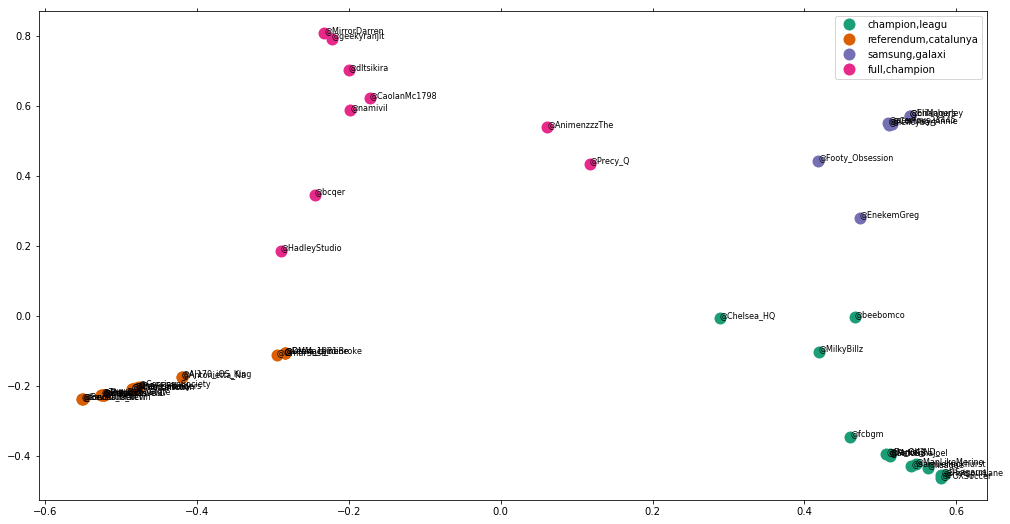

In [13]:
# plot cluster dokumen/tweet
plot_doc_cluster(xs, ys, clusters, acc_names)

Kemudian, fungsi plotting yang kedua digunakan untuk melihat Top-10 Kata paling probable atau yang paling besar proporsinya untuk topik tertentu.

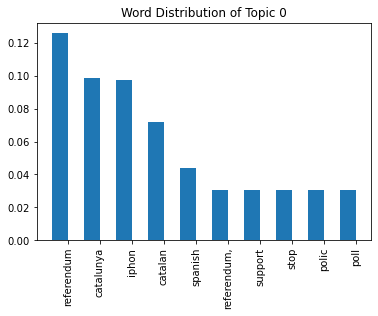

In [14]:
# plot word distribution untuk topic 0
plot_word_dist_per_topic(0, topics_matrix)

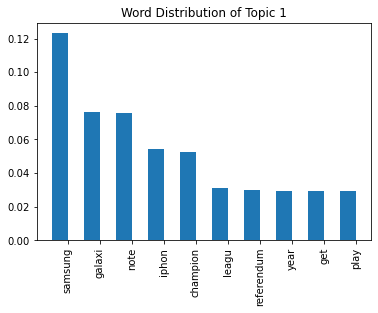

In [15]:
# plot word distribution untuk topic 1
plot_word_dist_per_topic(1, topics_matrix)

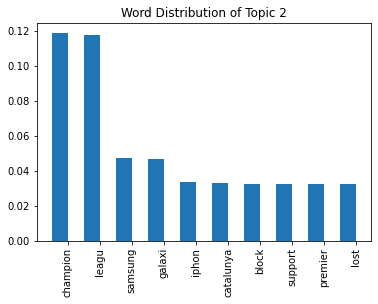

In [16]:
# plot word distribution untuk topic 2
plot_word_dist_per_topic(2, topics_matrix)

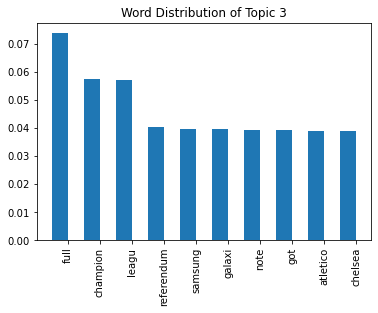

In [17]:
# plot word distribution untuk topic 3
plot_word_dist_per_topic(3, topics_matrix)